In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import time
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


# Adjust the options for viewing charts in notebook
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

# Adjust options for viewing dataframes in notebook
pd.set_option('display.width', 2000)

In [12]:
# Function for reading a data file
def read_data(name):
    df = pd.read_csv('./../../data/clean_data/' + name + '.csv')
    df['Hour'] = pd.to_datetime(df['Hour'])
    df = df.set_index('Hour')
    df.index.freq = 'h'
    return df

In [13]:
# Function for locating random batches from dataset

## Take dataset, length of training data, length of testing data and number of batches to extract as parameters
## Find a number of digits that represent the indices of the original dataset, where the extracted batches will start from
## Each subset dataset will not intersect with other datasets
def extract_batches(df, train_length, test_length, batch_count):
    start = time.time()
    random_int_list = []
    m = 0
    random.seed(1)
    data_end = len(df)
    new_data_size = train_length + test_length
    while m < batch_count:
        random_int = random.randint(0, data_end - new_data_size)
        q = 0
        for i in random_int_list:
            # Make sure batches do not overlap
            if i + new_data_size <= random_int or random_int + new_data_size <= i:
                pass
            else:
                q = 1
                # In case solution does not exist with current combination
                if time.time() - start > 2:
                    print('Restarted')
                    random_int_list = []
                    start = time.time()
                    m = 0

        # Prevent batches with 0 energy
        if df['Energy'][random_int: random_int + train_length].sum() == 0:
            q = 1
        elif df['Energy'][random_int +  train_length: random_int + new_data_size].sum() == 0:
            q = 1

        # Record the position of the batch
        if q == 0:
            random_int_list.append(random_int)
            m = m + 1
    return random_int_list

In [14]:
# Function for plotting training, predicted and actual values
def plot(train, predictions, actual):
    plt.plot(predictions, label='Forecast', color='blue')
    plt.plot(train, label='Train', color='orange')
    plt.plot(actual, label='Actual', color='red')
    plt.title('Forecast vs Actuals')
    plt.ylabel('Energy Consumption')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [15]:
# Function for forecasting using SARIMAX
def predict_SARIMAX(train, test_steps, order, seasonal_order):
    (p,d,q) = order
    (P,D,Q) = seasonal_order
    model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,24))
    fitted = model.fit()
    forecast = fitted.forecast(test_steps)
    forecast[forecast < 0] = 0
    return forecast

In [16]:
# Function for forecasting using Auto ARIMA with seasonal component
# This funtion has worse performance and is more time-demanding than SARIMAX
def predict_SARIMAX_auto(train, test_steps):
    model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=24,             # number in season
                      d=None,           # let model determine 'd'
                      seasonal=True,    # seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    model.fit(train)
    forecast = model.predict(n_periods=test_steps)
    forecast[forecast < 0] = 0
    return forecast

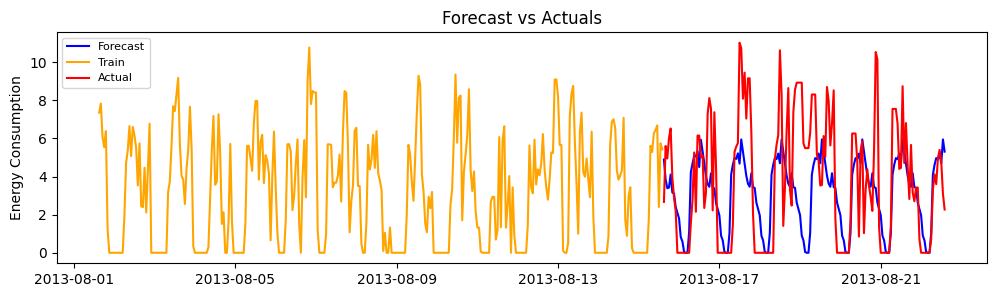

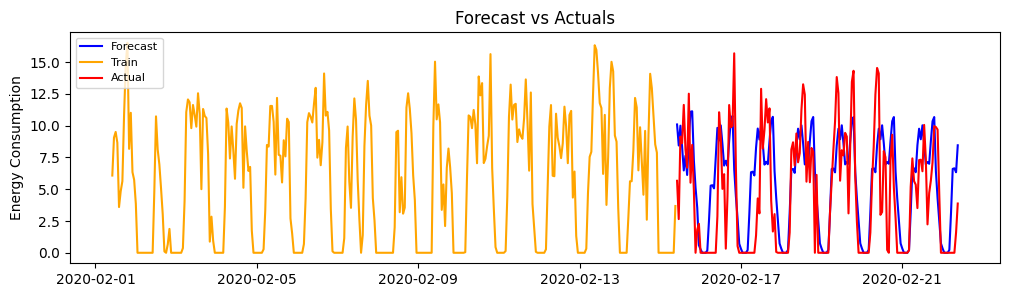

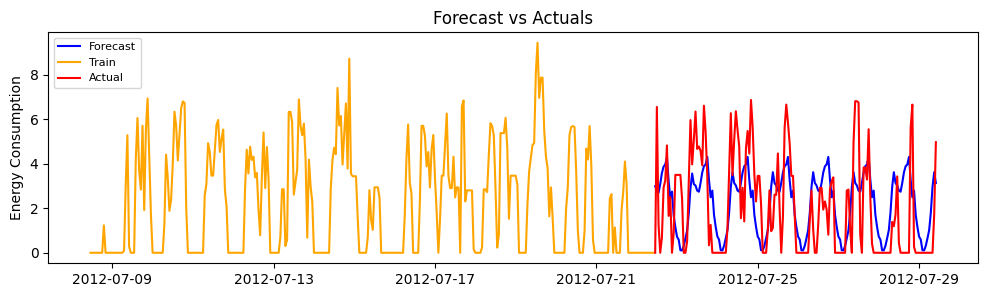

,Batch 1,Batch 2,Batch 3,Average
NRMSE,0.729,0.745,0.942,0.805
NMAE,0.530,0.552,0.759,0.614


In [17]:
# Testing SARIMAX on HAMILTON.txt with 3 random batches and plotting
df = read_data('HAMILTON')
train_length = 336 # 14 days
test_length = 168  # 7 days
start_index_list = extract_batches(df, train_length, test_length, 3)

# Create the empty results dataframe to hold the results
df_results = pd.DataFrame()
row_headers = ['NRMSE', 'NMAE']

for start_index in start_index_list:
    train = df[start_index: start_index + train_length]
    test = df[start_index + train_length: start_index + train_length + test_length]
    predictions = predict_SARIMAX(train['Energy'], test_length, (0,0,0), (1,1,1))

    # Normalised Root Mean Square Error
    nrmse_value = np.round(sqrt(mean_squared_error(test['Energy'], predictions))/test['Energy'].mean(), 3)
    # Normalised Mean Absolute Error
    nmae_value = np.round(mean_absolute_error(test['Energy'], predictions)/test['Energy'].mean(), 3)

    # Append the batch results to the results dataframe
    row = [nrmse_value, nmae_value]
    df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    plot(train['Energy'], predictions, test['Energy'])

# Calculate the average of each column
average_value_list = np.round(df_results.mean(), 3).tolist()

# Append the average to each column
df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)

# Reformat the results dataframe
df_results = df_results.transpose()
df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Average']

# Display results
display(df_results)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1656.880, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1405.265, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1452.222, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1928.383, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1413.054, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=1406.768, Time=1.30 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=1406.005, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=1602.007, Time=0.14 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=1406.463, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=1406.243, Time=0.24 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1448.034, Time=0.17 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept

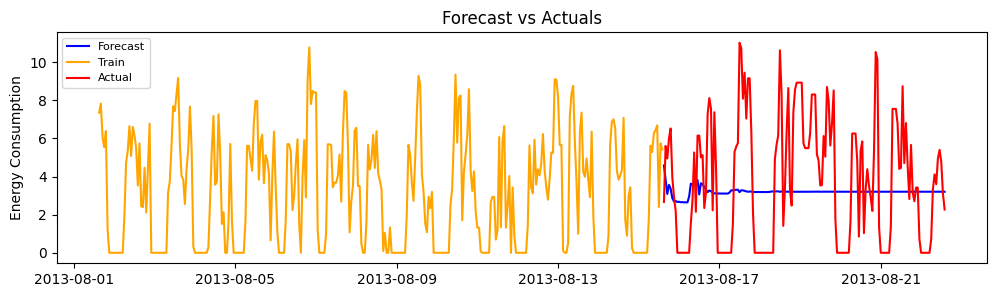

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2023.983, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1644.042, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1752.342, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2303.422, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1687.037, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=1638.215, Time=1.76 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=1862.010, Time=1.76 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=1640.177, Time=2.06 sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : AIC=1640.181, Time=1.68 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept   : AIC=1711.684, Time=1.42 sec
 ARIMA(2,0,1)(2,0,0)[24] intercept   : AIC=1638.703, Time=3.58 sec
 ARIMA(1,0,0)(2,0,0)[24]          

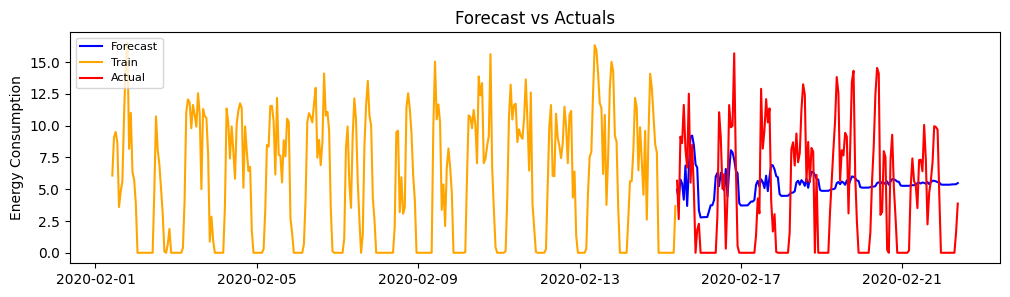

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1532.528, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1232.087, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1320.727, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1749.451, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1230.473, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=1232.126, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=1229.248, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=1231.029, Time=0.34 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=1231.047, Time=0.19 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=1231.069, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=1229.790, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept

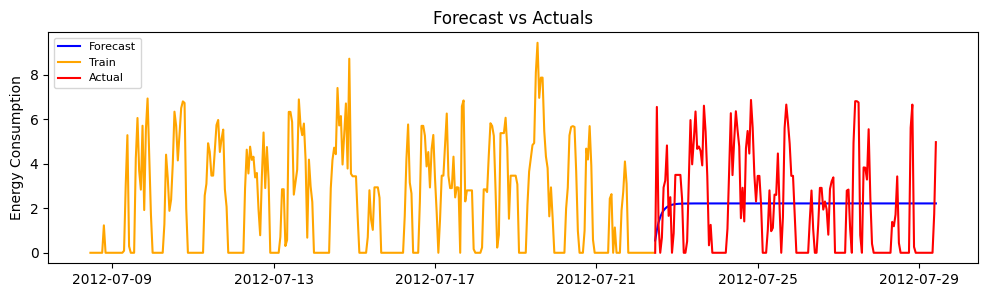

,Batch 1,Batch 2,Batch 3,Average
NRMSE,0.857,0.946,1.071,0.958
NMAE,0.739,0.833,0.937,0.836


In [18]:
# Testing Auto ARIMAX on HAMILTON.txt with 3 random batches and plotting
df = read_data('HAMILTON')
train_length = 336 # 14 days
test_length = 168  # 7 days
start_index_list = extract_batches(df, train_length, test_length, 3)

# Create the empty results dataframe to hold the results
df_results = pd.DataFrame()
row_headers = ['NRMSE', 'NMAE']

for start_index in start_index_list:
    train = df[start_index: start_index + train_length]
    test = df[start_index + train_length: start_index + train_length + test_length]
    predictions = predict_SARIMAX_auto(train['Energy'], test_length)

    # Normalised Root Mean Square Error
    nrmse_value = np.round(sqrt(mean_squared_error(test['Energy'], predictions))/test['Energy'].mean(), 3)
    # Normalised Mean Absolute Error
    nmae_value = np.round(mean_absolute_error(test['Energy'], predictions)/test['Energy'].mean(), 3)

    # Append the batch results to the results dataframe
    row = [nrmse_value, nmae_value]
    df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    plot(train['Energy'], predictions, test['Energy'])

# Calculate the average of each column
average_value_list = np.round(df_results.mean(), 3).tolist()

# Append the average to each column
df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)

# Reformat the results dataframe
df_results = df_results.transpose()
df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Average']

# Display results
display(df_results)

In [19]:
# Function for running the accuracy tests and collecting the results
def analyse(df, train_length, test_length, batch_count):
    # Find appropriate (random) indices for batches to prevent overlap
    start_index_list = extract_batches(df, train_length, test_length, batch_count)

    # Create the empty results dataframe to hold the results
    df_results = pd.DataFrame()
    row_headers = ['Energy (kWh)', 'NRMSE', 'NMAE']

    # For each batch, get testing and training data and make predictions
    for start_index in start_index_list:
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]
        predictions = predict_SARIMAX(train['Energy'], test_length, (0,0,0), (1,1,1))

        # Calculate total energy demand in batch
        demand_value = np.round(test['Energy'].sum(), 3)

        # Prevent dividing by zero
        if test['Energy'].mean() != 0:
            test_mean = test['Energy'].mean()
        else:
            test_mean = 1

        # Calculate accuracy metrics for each batch:
        ## Record Normalised Root Mean Square Error of batch
        nrmse_value = np.round(sqrt(mean_squared_error(test['Energy'], predictions))/test_mean, 3)
        ## Record Normalised Mean Absolute Error of batch
        nmae_value = np.round(mean_absolute_error(test['Energy'], predictions)/test_mean, 3)

        # Append the batch results to the results dataframe
        row = [demand_value, nrmse_value, nmae_value]
        df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    # Calculate the average of each column
    average_value_list = np.round(df_results.mean(), 3).tolist()
    # Calculate the minimum of each column
    min_value_list = np.round(df_results.min(), 3).tolist()
    # Calculate the maximum of each column
    max_value_list = np.round(df_results.max(), 3).tolist()
    # Calculate the standard deviation of each column
    stddev_value_list = np.round(df_results.std(), 3).tolist()
 
    # Append the average to each column
    df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)
    # Append the minimum to each column
    df_results = pd.concat([df_results, pd.DataFrame([min_value_list], columns=row_headers)], ignore_index=True)
    # Append the maximum to each column
    df_results = pd.concat([df_results, pd.DataFrame([max_value_list], columns=row_headers)], ignore_index=True)
    # Append the standard deviation to each column
    df_results = pd.concat([df_results, pd.DataFrame([stddev_value_list], columns=row_headers)], ignore_index=True)

    # Reformat the results dataframe
    df_results = df_results.transpose()
    df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5', 'Batch 6', 'Batch 7', 'Batch 8', 'Batch 9', 'Batch 10',
                            'Average', 'Minimum', 'Maximum', 'Std. Dev.']
    
    # Display results
    display(df_results)

    return df_results

In [20]:
# Conducting extensive batch testing of accuracy metrics on different forecast periods and training period lengths, with 10 random batches each
def main():
    # Make the directory for the results
    if os.path.isdir('../../data/accuracy_results/SARIMA'):
        pass
    else:
        os.makedirs('../../data/accuracy_results/SARIMA')

    print('-- Performance metric testing --')
    for name in ['WEBSTER', 'CAMBRIDGE', 'MPL', 'RINCONADA LIB', 'TED THOMPSON', 'HAMILTON', 'HIGH', 'BRYANT']:

        df = read_data(name)
        print('\n{}'.format(name))
        file_name = '../../data/accuracy_results/SARIMA/' + name + '_SARIMA.xlsx'

        # Write the tables to appropriate xlsx files
        with pd.ExcelWriter(file_name, mode='w', engine='xlsxwriter') as writer:

            # Run the tests for each training type
            q = 0
            while q < 3:
                # Modify execution parameters if needed
                test_length = [336, 168, 72, 24]                               # Hours in testing set
                batch_count = [10, 10, 10, 10]                                 # Batch count
                start_row = [1, 6, 11, 16]                                     # Row position in xlsx file to write results in
                durations = ['14 Days', '7 Days', '3 Days', '1 Day']           # Durations of batches, used for titles

                if q == 0:
                    # 1. Two weeks training data
                    print('-- Two Weeks Training Data --')
                    pd.DataFrame(['14 Days Training']).to_excel(writer, sheet_name=name, startrow=0, header=None, index=None)

                    train_length = [336, 336, 336, 336]                        # Hours in training set
                    start_col = 0                                              # Column position in xlsx file to write results in
                elif q == 1:
                    # 2. 75:25 Ratio of training to testing data
                    print('-- 75:25 Ratio of Training to Testing Data --')
                    pd.DataFrame(['Training:Testing = 75:25']).to_excel(writer, sheet_name=name, startrow=0, startcol=16, header=None, index=None)
    
                    train_length = [1008, 504, 216, 72]                        # Hours in training set
                    start_col = 16                                             # Column position in xlsx file to write results in
                else:
                    # 3. 50:50 Ratio of training to testing data
                    print('-- 50:50 Ratio of Training to Testing Data --')
                    pd.DataFrame(['Training:Testing = 50:50']).to_excel(writer, sheet_name=name, startrow=0, startcol=32, header=None, index=None)
    
                    train_length = [336, 168, 72, 24]                          # Hours in training set
                    start_col = 32                                             # Column position in xlsx file to write results in

                all_results_list = []

                i = 0
                while i < len(test_length):
                    print('{} Ahead Forecast:'.format(durations[i]))

                    # Run set of batches and collect results
                    df_results = analyse(df, train_length[i], test_length[i], batch_count[i])
                    all_results_list.append(df_results)

                    # Write results to xlsx file
                    df_results.to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                    pd.DataFrame(['{} Forecast'.format(durations[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                    i = i + 1

                # Create summary dataframes
                df_summary_avg = pd.concat([df['Average'] for df in all_results_list], axis="columns")
                df_summary_min = pd.concat([df['Minimum'] for df in all_results_list], axis="columns")
                df_summary_max = pd.concat([df['Maximum'] for df in all_results_list], axis="columns")
                df_summary_stddev = pd.concat([df['Std. Dev.'] for df in all_results_list], axis="columns")

                for i in [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]:
                    i.columns = durations

                # Modify summary parameters if needed
                start_row = [21, 26, 31, 36]                                                        # Row position in xlsx file to write results in
                summary_name = [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]  # Summary reference list
                print_title = ['Average', 'Minimum', 'Maximum', 'Standard Deviation']               # Title for printing results
                summary_title = ['Avg.', 'Min.', 'Max.', 'Std.Dev.']                                # Dataframe title in xlsx file

                i = 0
                while i < 4:
                    print('{} Values Summary - {}:'.format(print_title[i], name))

                    # Display summary
                    display(summary_name[i])

                    # Write summary to xlsx file
                    summary_name[i].to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                    pd.DataFrame(['{} Forecast'.format(summary_title[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                    i = i + 1

                q = q + 1

            # Adjust the columns' widths
            worksheet = writer.sheets[name]
            workbook = writer.book
            worksheet.set_column(0, 0, 15)
            worksheet.set_column(16, 16, 20)
            worksheet.set_column(32, 32, 20)
            # Adjust cell formating
            format1 = workbook.add_format({'bg_color': '#EDEDED', 'border': 1})
            worksheet.conditional_format(0, 0, 39, 46, {'type': 'no_blanks', 'format': format1})

main()

-- Performance metric testing --



WEBSTER
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.190,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
NRMSE,0.603,0.709,0.744,0.749,0.471,0.748,0.430,0.855,1.604,0.801,0.771,0.430,1.604,0.324
NMAE,0.459,0.498,0.543,0.529,0.370,0.527,0.347,0.611,0.995,0.567,0.545,0.347,0.995,0.179


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1642.875,1378.006,1231.265,1109.232,1947.639,1272.497,1947.678,1027.345,179.855,1343.281,1307.967,179.855,1947.678,509.329
NRMSE,0.559,0.768,0.702,0.727,0.528,0.763,0.416,0.921,2.161,0.631,0.818,0.416,2.161,0.493
NMAE,0.426,0.541,0.503,0.508,0.409,0.528,0.339,0.653,1.469,0.433,0.581,0.339,1.469,0.324


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),674.331,689.480,574.627,548.452,825.515,593.708,839.197,570.248,62.273,737.272,611.510,62.273,839.197,219.215
NRMSE,0.590,0.612,0.658,0.564,0.604,0.586,0.456,0.654,2.866,0.547,0.814,0.456,2.866,0.723
NMAE,0.463,0.472,0.473,0.373,0.476,0.403,0.373,0.468,2.035,0.382,0.592,0.373,2.035,0.509


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),229.586,163.234,271.363,245.623,111.703,179.943,227.082,167.094,6.218,255.276,185.712,6.218,271.363,80.265
NRMSE,0.606,0.614,0.572,0.638,1.796,0.434,0.618,0.524,8.893,0.528,1.522,0.434,8.893,2.619
NMAE,0.492,0.476,0.386,0.456,1.438,0.316,0.500,0.398,6.711,0.413,1.159,0.316,6.711,1.977


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1307.967,611.510,185.712
NRMSE,0.771,0.818,0.814,1.522
NMAE,0.545,0.581,0.592,1.159


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,179.855,62.273,6.218
NRMSE,0.430,0.416,0.456,0.434
NMAE,0.347,0.339,0.373,0.316


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,1947.678,839.197,271.363
NRMSE,1.604,2.161,2.866,8.893
NMAE,0.995,1.469,2.035,6.711


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,509.329,219.215,80.265
NRMSE,0.324,0.493,0.723,2.619
NMAE,0.179,0.324,0.509,1.977


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),512.484,2623.430,2453.461,2014.774,4238.914,2384.657,1061.268,2041.756,745.308,3793.892,2186.994,512.484,4238.914,1215.342
NRMSE,6.045,0.675,0.681,0.881,0.425,0.676,1.160,0.670,1.457,0.447,1.312,0.425,6.045,1.693
NMAE,5.028,0.470,0.484,0.633,0.339,0.482,0.781,0.508,0.928,0.350,1.000,0.339,5.028,1.427


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1682.311,1232.184,1202.892,1047.740,2022.188,1408.102,1965.443,1121.042,442.457,961.306,1308.566,442.457,2022.188,480.887
NRMSE,0.636,0.707,0.763,0.769,0.406,0.652,0.435,0.720,1.355,0.745,0.719,0.406,1.355,0.258
NMAE,0.505,0.512,0.563,0.546,0.322,0.467,0.351,0.504,0.799,0.555,0.512,0.322,0.799,0.130


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),782.450,555.498,505.135,631.427,951.196,391.551,942.332,445.810,126.156,484.981,581.654,126.156,951.196,255.474
NRMSE,0.609,0.766,0.704,0.775,0.324,0.837,0.367,0.904,1.999,0.785,0.807,0.324,1.999,0.461
NMAE,0.478,0.574,0.504,0.564,0.255,0.682,0.285,0.639,1.368,0.576,0.592,0.255,1.368,0.306


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),296.216,60.465,172.158,147.807,277.709,82.775,310.803,103.316,8.336,255.917,171.55,8.336,310.803,108.218
NRMSE,0.913,1.882,1.120,1.181,0.449,1.523,0.658,1.624,18.766,0.480,2.86,0.449,18.766,5.610
NMAE,0.754,1.261,0.968,0.765,0.361,1.125,0.546,1.043,11.181,0.292,1.83,0.292,11.181,3.301


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2186.994,1308.566,581.654,171.55
NRMSE,1.312,0.719,0.807,2.86
NMAE,1.000,0.512,0.592,1.83


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),512.484,442.457,126.156,8.336
NRMSE,0.425,0.406,0.324,0.449
NMAE,0.339,0.322,0.255,0.292


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4238.914,2022.188,951.196,310.803
NRMSE,6.045,1.355,1.999,18.766
NMAE,5.028,0.799,1.368,11.181


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1215.342,480.887,255.474,108.218
NRMSE,1.693,0.258,0.461,5.610
NMAE,1.427,0.130,0.306,3.301


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.190,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
NRMSE,0.603,0.709,0.744,0.749,0.471,0.748,0.430,0.855,1.604,0.801,0.771,0.430,1.604,0.324
NMAE,0.459,0.498,0.543,0.529,0.370,0.527,0.347,0.611,0.995,0.567,0.545,0.347,0.995,0.179


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1620.515,1218.634,1444.036,1071.478,1985.305,945.207,2026.609,1192.549,401.147,1137.343,1304.282,401.147,2026.609,488.940
NRMSE,0.717,0.904,0.613,0.976,0.405,0.915,0.494,0.759,1.525,0.719,0.803,0.405,1.525,0.313
NMAE,0.590,0.620,0.445,0.701,0.299,0.688,0.378,0.514,0.856,0.538,0.563,0.299,0.856,0.165


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),854.792,257.110,525.899,505.714,845.222,341.503,1022.777,455.865,44.450,474.455,532.779,44.450,1022.777,298.618
NRMSE,0.824,1.251,1.015,1.048,0.397,1.410,0.592,1.090,10.303,1.229,1.916,0.397,10.303,2.963
NMAE,0.652,0.909,0.839,0.719,0.319,0.985,0.460,0.761,6.392,0.901,1.294,0.319,6.392,1.803


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),58.975,100.873,206.136,228.316,342.823,163.299,179.004,202.791,85.068,212.942,178.023,58.975,342.823,82.526
NRMSE,4.576,1.107,0.582,0.726,0.618,0.753,0.914,0.647,1.459,0.831,1.221,0.582,4.576,1.208
NMAE,3.049,0.745,0.396,0.522,0.501,0.556,0.679,0.455,0.966,0.580,0.845,0.396,3.049,0.792


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1304.282,532.779,178.023
NRMSE,0.771,0.803,1.916,1.221
NMAE,0.545,0.563,1.294,0.845


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,401.147,44.450,58.975
NRMSE,0.430,0.405,0.397,0.582
NMAE,0.347,0.299,0.319,0.396


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,2026.609,1022.777,342.823
NRMSE,1.604,1.525,10.303,4.576
NMAE,0.995,0.856,6.392,3.049


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,488.940,298.618,82.526
NRMSE,0.324,0.313,2.963,1.208
NMAE,0.179,0.165,1.803,0.792



CAMBRIDGE
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
NRMSE,0.819,0.970,0.831,0.906,0.462,0.874,0.511,0.804,1.058,1.179,0.841,0.462,1.179,0.221
NMAE,0.565,0.634,0.539,0.584,0.344,0.626,0.399,0.585,0.737,0.752,0.576,0.344,0.752,0.129


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1444.492,1369.866,928.969,900.689,984.465,1368.427,970.418,633.994,606.399,776.700,998.442,606.399,1444.492,302.739
NRMSE,0.946,0.982,0.750,0.871,0.423,0.865,0.526,0.893,1.101,0.948,0.830,0.423,1.101,0.210
NMAE,0.663,0.649,0.491,0.588,0.317,0.628,0.414,0.664,0.774,0.567,0.576,0.317,0.774,0.135


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),358.073,650.140,419.428,466.132,402.897,709.202,353.539,359.670,223.540,429.462,437.208,223.540,709.202,144.006
NRMSE,1.833,0.929,0.682,0.810,0.434,0.695,0.588,0.531,1.022,0.830,0.835,0.434,1.833,0.394
NMAE,1.295,0.622,0.434,0.565,0.319,0.496,0.445,0.376,0.816,0.477,0.584,0.319,1.295,0.286


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.485,216.404,162.154,175.727,113.535,193.151,80.726,132.508,65.550,112.353,137.759,65.550,216.404,48.497
NRMSE,2.069,0.927,0.636,0.690,0.670,0.661,0.939,0.445,1.294,0.903,0.923,0.445,2.069,0.465
NMAE,1.434,0.615,0.382,0.538,0.504,0.446,0.696,0.312,0.955,0.508,0.639,0.312,1.434,0.332


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,998.442,437.208,137.759
NRMSE,0.841,0.830,0.835,0.923
NMAE,0.576,0.576,0.584,0.639


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,606.399,223.540,65.550
NRMSE,0.462,0.423,0.434,0.445
NMAE,0.344,0.317,0.319,0.312


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1444.492,709.202,216.404
NRMSE,1.179,1.101,1.833,2.069
NMAE,0.752,0.774,1.295,1.434


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,302.739,144.006,48.497
NRMSE,0.221,0.210,0.394,0.465
NMAE,0.129,0.135,0.286,0.332


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.751,2033.177,1851.882,2289.041,1817.842,1349.984,1387.975,1342.536,1569.538,3212.624,1746.935,614.751,3212.624,691.486
NRMSE,5.771,0.875,0.841,0.752,0.546,0.696,0.952,0.959,0.591,0.663,1.265,0.546,5.771,1.590
NMAE,4.184,0.633,0.541,0.503,0.424,0.475,0.674,0.624,0.443,0.471,0.897,0.424,4.184,1.158


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1654.364,1102.118,952.120,946.744,928.296,1157.348,1015.897,642.759,621.408,704.220,972.527,621.408,1654.364,302.727
NRMSE,0.706,0.814,0.887,0.868,0.500,0.794,0.484,0.694,1.022,0.983,0.775,0.484,1.022,0.182
NMAE,0.478,0.618,0.571,0.557,0.374,0.564,0.381,0.497,0.715,0.744,0.550,0.374,0.744,0.124


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),918.300,390.429,333.129,264.730,426.859,213.789,450.542,304.856,175.958,225.563,370.416,175.958,918.300,213.534
NRMSE,0.921,1.051,1.101,1.595,0.507,1.307,0.494,0.954,1.659,1.115,1.070,0.494,1.659,0.390
NMAE,0.707,0.657,0.681,1.032,0.372,0.986,0.363,0.741,1.158,0.796,0.749,0.363,1.158,0.261


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),331.914,91.580,93.949,163.655,114.851,46.170,147.900,81.608,105.256,96.898,127.378,46.170,331.914,79.047
NRMSE,0.628,1.183,1.485,0.558,0.842,5.868,0.536,1.082,0.678,0.856,1.372,0.536,5.868,1.609
NMAE,0.478,0.813,1.080,0.349,0.645,3.928,0.439,0.739,0.576,0.552,0.960,0.349,3.928,1.064


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1746.935,972.527,370.416,127.378
NRMSE,1.265,0.775,1.070,1.372
NMAE,0.897,0.550,0.749,0.960


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),614.751,621.408,175.958,46.170
NRMSE,0.546,0.484,0.494,0.536
NMAE,0.424,0.374,0.363,0.349


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3212.624,1654.364,918.300,331.914
NRMSE,5.771,1.022,1.659,5.868
NMAE,4.184,0.744,1.158,3.928


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),691.486,302.727,213.534,79.047
NRMSE,1.590,0.182,0.390,1.609
NMAE,1.158,0.124,0.261,1.064


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
NRMSE,0.819,0.970,0.831,0.906,0.462,0.874,0.511,0.804,1.058,1.179,0.841,0.462,1.179,0.221
NMAE,0.565,0.634,0.539,0.584,0.344,0.626,0.399,0.585,0.737,0.752,0.576,0.344,0.752,0.129


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1714.224,779.583,946.577,643.208,856.199,690.584,921.932,798.814,504.007,621.705,847.683,504.007,1714.224,334.822
NRMSE,0.857,1.199,0.963,1.750,0.599,1.223,0.544,0.650,1.335,0.999,1.012,0.544,1.750,0.376
NMAE,0.591,0.776,0.616,1.175,0.437,0.951,0.408,0.457,0.931,0.693,0.704,0.408,1.175,0.254


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),888.729,245.842,273.891,400.955,404.986,262.901,469.895,235.760,320.806,187.723,369.149,187.723,888.729,203.038
NRMSE,0.703,1.431,1.291,0.928,0.550,2.565,0.530,1.297,1.103,2.089,1.249,0.530,2.565,0.659
NMAE,0.527,0.855,0.845,0.627,0.395,1.676,0.413,0.873,0.797,1.449,0.846,0.395,1.676,0.421


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),274.461,61.458,146.791,154.864,140.382,196.849,42.685,161.386,60.771,115.513,135.516,42.685,274.461,70.199
NRMSE,0.767,0.907,0.835,0.797,0.657,0.572,2.147,0.580,1.209,1.451,0.992,0.572,2.147,0.491
NMAE,0.595,0.510,0.592,0.539,0.430,0.411,1.366,0.403,0.790,0.969,0.661,0.403,1.366,0.305


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,847.683,369.149,135.516
NRMSE,0.841,1.012,1.249,0.992
NMAE,0.576,0.704,0.846,0.661


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,504.007,187.723,42.685
NRMSE,0.462,0.544,0.530,0.572
NMAE,0.344,0.408,0.395,0.403


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1714.224,888.729,274.461
NRMSE,1.179,1.750,2.565,2.147
NMAE,0.752,1.175,1.676,1.366


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,334.822,203.038,70.199
NRMSE,0.221,0.376,0.659,0.491
NMAE,0.129,0.254,0.421,0.305



MPL
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.760,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
NRMSE,0.974,0.978,0.977,0.799,0.879,0.504,2.608,0.929,0.520,0.708,0.988,0.504,2.608,0.597
NMAE,0.642,0.760,0.678,0.600,0.664,0.384,1.180,0.677,0.397,0.530,0.651,0.384,1.180,0.223


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),511.493,673.730,579.509,888.775,607.683,1521.253,108.595,614.179,1373.388,735.485,761.409,108.595,1521.253,414.123
NRMSE,1.113,1.053,0.996,0.715,0.930,0.467,2.490,0.970,0.463,0.671,0.987,0.463,2.490,0.578
NMAE,0.736,0.815,0.652,0.548,0.708,0.368,1.140,0.713,0.352,0.521,0.655,0.352,1.140,0.230


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),254.306,262.123,256.380,318.993,239.791,647.548,58.685,287.509,553.951,279.410,315.870,58.685,647.548,166.995
NRMSE,1.021,1.004,1.055,0.791,0.937,0.441,2.480,0.882,0.488,0.658,0.976,0.441,2.480,0.572
NMAE,0.662,0.805,0.718,0.616,0.710,0.351,1.153,0.664,0.351,0.526,0.656,0.351,1.153,0.231


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),93.038,88.064,88.879,133.649,89.857,249.203,2.349,112.075,207.702,103.608,116.842,2.349,249.203,68.531
NRMSE,0.669,1.088,1.136,0.677,0.594,0.460,9.423,0.855,0.448,0.571,1.592,0.448,9.423,2.762
NMAE,0.461,0.872,0.780,0.493,0.413,0.365,5.018,0.603,0.338,0.449,0.979,0.338,5.018,1.430


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,761.409,315.870,116.842
NRMSE,0.988,0.987,0.976,1.592
NMAE,0.651,0.655,0.656,0.979


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,108.595,58.685,2.349
NRMSE,0.504,0.463,0.441,0.448
NMAE,0.384,0.352,0.351,0.338


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1521.253,647.548,249.203
NRMSE,2.608,2.490,2.480,9.423
NMAE,1.180,1.140,1.153,5.018


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,414.123,166.995,68.531
NRMSE,0.597,0.578,0.572,2.762
NMAE,0.223,0.230,0.231,1.430


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),250.184,369.717,1055.324,1491.290,1237.810,3052.889,414.178,1303.993,764.207,1358.243,1129.784,250.184,3052.889,811.440
NRMSE,3.911,2.001,0.966,0.843,0.838,0.442,1.820,0.826,1.230,1.031,1.391,0.442,3.911,1.004
NMAE,2.740,1.391,0.754,0.654,0.621,0.339,1.130,0.617,0.917,0.719,0.988,0.339,2.740,0.682


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),756.301,684.030,724.748,687.017,632.536,1408.437,85.769,633.630,1256.622,750.467,761.956,85.769,1408.437,359.987
NRMSE,0.834,0.893,0.887,0.912,0.789,0.530,2.700,0.822,0.566,0.747,0.968,0.530,2.700,0.623
NMAE,0.561,0.704,0.659,0.693,0.614,0.390,1.319,0.601,0.447,0.557,0.654,0.390,1.319,0.254


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),217.072,338.499,174.794,384.358,224.724,564.477,65.751,230.083,508.980,267.065,297.580,65.751,564.477,153.198
NRMSE,1.398,0.831,1.232,0.733,1.015,0.427,2.537,1.048,0.587,0.791,1.060,0.427,2.537,0.595
NMAE,0.857,0.694,0.769,0.574,0.738,0.330,1.092,0.778,0.460,0.627,0.692,0.330,1.092,0.212


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),94.542,124.964,42.110,106.791,65.512,157.594,65.901,280.144,93.208,22.979,105.374,22.979,280.144,72.924
NRMSE,0.872,1.120,1.997,1.077,1.232,0.732,1.033,0.407,0.398,4.427,1.330,0.398,4.427,1.180
NMAE,0.500,0.854,1.316,0.701,0.781,0.597,0.727,0.286,0.265,2.840,0.887,0.265,2.840,0.749


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1129.784,761.956,297.580,105.374
NRMSE,1.391,0.968,1.060,1.330
NMAE,0.988,0.654,0.692,0.887


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),250.184,85.769,65.751,22.979
NRMSE,0.442,0.530,0.427,0.398
NMAE,0.339,0.390,0.330,0.265


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3052.889,1408.437,564.477,280.144
NRMSE,3.911,2.700,2.537,4.427
NMAE,2.740,1.319,1.092,2.840


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),811.440,359.987,153.198,72.924
NRMSE,1.004,0.623,0.595,1.180
NMAE,0.682,0.254,0.212,0.749


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.760,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
NRMSE,0.974,0.978,0.977,0.799,0.879,0.504,2.608,0.929,0.520,0.708,0.988,0.504,2.608,0.597
NMAE,0.642,0.760,0.678,0.600,0.664,0.384,1.180,0.677,0.397,0.530,0.651,0.384,1.180,0.223


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),527.492,875.126,366.614,827.556,596.389,1468.923,92.626,448.117,1212.038,704.425,711.931,92.626,1468.923,405.921
NRMSE,1.114,0.731,1.482,0.774,0.958,0.571,3.428,1.132,0.667,0.761,1.162,0.571,3.428,0.842
NMAE,0.715,0.577,0.887,0.583,0.690,0.438,1.015,0.839,0.532,0.570,0.685,0.438,1.015,0.181


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),231.971,338.742,154.335,317.732,226.719,486.703,218.418,664.265,303.184,124.067,306.614,124.067,664.265,162.535
NRMSE,0.965,1.107,1.604,0.869,1.036,0.838,1.084,0.540,0.801,2.264,1.111,0.540,2.264,0.489
NMAE,0.571,0.844,0.921,0.583,0.666,0.625,0.759,0.389,0.487,1.461,0.731,0.389,1.461,0.302


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),113.512,97.638,60.083,76.293,113.553,145.788,64.007,242.127,67.668,65.646,104.632,60.083,242.127,55.907
NRMSE,0.753,1.133,1.556,1.400,1.235,1.126,1.343,0.515,1.997,2.012,1.307,0.515,2.012,0.477
NMAE,0.474,0.825,0.867,0.936,0.763,1.012,0.980,0.399,1.332,1.366,0.895,0.399,1.366,0.313


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,711.931,306.614,104.632
NRMSE,0.988,1.162,1.111,1.307
NMAE,0.651,0.685,0.731,0.895


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,92.626,124.067,60.083
NRMSE,0.504,0.571,0.540,0.515
NMAE,0.384,0.438,0.389,0.399


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1468.923,664.265,242.127
NRMSE,2.608,3.428,2.264,2.012
NMAE,1.180,1.015,1.461,1.366


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,405.921,162.535,55.907
NRMSE,0.597,0.842,0.489,0.477
NMAE,0.223,0.181,0.302,0.313



RINCONADA LIB
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
NRMSE,1.281,1.182,1.219,1.454,1.651,0.511,1.348,0.624,1.413,0.859,1.154,0.511,1.651,0.372
NMAE,0.858,0.877,0.958,1.134,1.253,0.380,0.973,0.512,1.100,0.600,0.864,0.380,1.253,0.285


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),471.782,428.887,380.735,381.345,341.868,1122.184,360.284,1102.759,345.335,321.891,525.707,321.891,1122.184,312.365
NRMSE,1.271,1.040,1.301,1.216,1.611,0.484,1.478,0.604,1.478,1.603,1.209,0.484,1.611,0.394
NMAE,0.800,0.772,0.987,0.922,1.163,0.361,1.051,0.490,1.167,1.080,0.879,0.361,1.167,0.276


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),312.659,226.637,145.732,228.451,124.200,449.338,111.564,498.917,125.843,160.059,238.340,111.564,498.917,139.299
NRMSE,1.071,0.996,1.210,1.073,1.437,0.536,1.620,0.600,1.472,1.312,1.133,0.536,1.620,0.357
NMAE,0.690,0.767,1.011,0.833,1.054,0.408,1.260,0.491,1.165,0.956,0.863,0.408,1.260,0.279


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.522,63.175,21.875,61.345,49.208,153.676,48.601,196.143,49.138,85.276,77.796,21.875,196.143,54.489
NRMSE,0.941,0.794,2.276,0.976,1.378,0.476,0.841,0.489,1.332,1.145,1.065,0.476,2.276,0.524
NMAE,0.667,0.571,1.925,0.818,0.972,0.339,0.717,0.399,1.062,0.955,0.842,0.339,1.925,0.450


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,525.707,238.340,77.796
NRMSE,1.154,1.209,1.133,1.065
NMAE,0.864,0.879,0.863,0.842


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,321.891,111.564,21.875
NRMSE,0.511,0.484,0.536,0.476
NMAE,0.380,0.361,0.408,0.339


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1122.184,498.917,196.143
NRMSE,1.651,1.611,1.620,2.276
NMAE,1.253,1.167,1.260,1.925


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,312.365,139.299,54.489
NRMSE,0.372,0.394,0.357,0.524
NMAE,0.285,0.276,0.279,0.450


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),450.827,1279.165,917.640,539.919,831.107,2257.982,910.708,1456.058,642.601,1680.822,1096.683,450.827,2257.982,569.870
NRMSE,2.266,0.862,1.143,1.506,1.286,0.494,1.187,0.776,1.310,0.701,1.153,0.494,2.266,0.502
NMAE,1.780,0.611,0.927,1.229,0.989,0.395,0.927,0.580,0.806,0.576,0.882,0.395,1.780,0.400


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),472.587,377.623,526.628,213.342,287.926,1135.132,448.047,1226.086,389.848,669.564,574.678,213.342,1226.086,343.510
NRMSE,1.280,1.277,1.143,1.878,1.676,0.513,1.209,0.623,1.304,0.758,1.166,0.513,1.878,0.435
NMAE,0.922,0.908,0.922,1.541,1.334,0.392,0.890,0.517,0.960,0.556,0.894,0.392,1.541,0.354


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),70.735,237.027,167.587,198.014,84.149,412.500,101.323,404.921,346.946,126.274,214.948,70.735,412.500,130.910
NRMSE,6.675,0.814,1.253,1.442,1.740,0.605,1.713,0.722,0.954,1.164,1.708,0.605,6.675,1.789
NMAE,3.846,0.590,0.964,0.974,1.419,0.437,1.360,0.585,0.751,0.741,1.167,0.437,3.846,0.995


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),38.600,55.619,28.035,81.869,11.981,116.475,91.594,132.153,116.450,47.923,72.070,11.981,132.153,41.570
NRMSE,1.240,1.497,2.679,1.372,3.545,0.921,1.156,0.856,0.747,1.683,1.570,0.747,3.545,0.887
NMAE,0.769,1.031,1.408,1.033,1.960,0.721,0.714,0.717,0.586,1.030,0.997,0.586,1.960,0.416


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1096.683,574.678,214.948,72.070
NRMSE,1.153,1.166,1.708,1.570
NMAE,0.882,0.894,1.167,0.997


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),450.827,213.342,70.735,11.981
NRMSE,0.494,0.513,0.605,0.747
NMAE,0.395,0.392,0.437,0.586


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2257.982,1226.086,412.500,132.153
NRMSE,2.266,1.878,6.675,3.545
NMAE,1.780,1.541,3.846,1.960


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),569.870,343.510,130.910,41.570
NRMSE,0.502,0.435,1.789,0.887
NMAE,0.400,0.354,0.995,0.416


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
NRMSE,1.281,1.182,1.219,1.454,1.651,0.511,1.348,0.624,1.413,0.859,1.154,0.511,1.651,0.372
NMAE,0.858,0.877,0.958,1.134,1.253,0.380,0.973,0.512,1.100,0.600,0.864,0.380,1.253,0.285


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),404.187,549.226,395.254,337.279,281.411,1061.526,208.546,1085.027,563.583,341.123,522.716,208.546,1085.027,309.744
NRMSE,1.634,0.814,1.353,1.555,2.967,0.618,2.765,0.620,1.177,1.278,1.478,0.618,2.967,0.814
NMAE,0.988,0.614,1.024,1.054,2.113,0.450,2.382,0.511,0.908,0.794,1.084,0.450,2.382,0.652


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.608,220.220,133.578,146.556,242.090,352.598,267.100,481.181,261.002,155.876,236.281,102.608,481.181,114.644
NRMSE,1.683,1.024,1.587,1.819,1.451,0.734,1.162,0.742,1.086,1.697,1.299,0.734,1.819,0.402
NMAE,1.075,0.720,0.980,1.379,0.960,0.545,0.827,0.602,0.834,0.964,0.889,0.545,1.379,0.243


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.019,101.869,25.196,84.321,15.759,135.812,66.190,160.829,65.484,23.584,72.806,15.759,160.829,48.651
NRMSE,1.603,0.815,5.205,1.192,3.082,1.121,1.157,0.886,1.186,4.494,2.074,0.815,5.205,1.606
NMAE,1.032,0.516,4.034,1.052,1.733,0.865,0.806,0.748,0.767,2.363,1.392,0.516,4.034,1.079


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,522.716,236.281,72.806
NRMSE,1.154,1.478,1.299,2.074
NMAE,0.864,1.084,0.889,1.392


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,208.546,102.608,15.759
NRMSE,0.511,0.618,0.734,0.815
NMAE,0.380,0.450,0.545,0.516


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1085.027,481.181,160.829
NRMSE,1.651,2.967,1.819,5.205
NMAE,1.253,2.382,1.379,4.034


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,309.744,114.644,48.651
NRMSE,0.372,0.814,0.402,1.606
NMAE,0.285,0.652,0.243,1.079



TED THOMPSON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
NRMSE,0.904,0.981,1.175,1.107,0.644,1.069,0.692,0.941,1.551,1.603,1.067,0.644,1.603,0.317
NMAE,0.626,0.604,0.796,0.754,0.512,0.724,0.564,0.759,1.093,1.053,0.748,0.512,1.093,0.194


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),970.861,771.519,738.332,794.073,570.688,1067.644,517.082,452.662,358.297,747.915,698.907,358.297,1067.644,224.688
NRMSE,1.213,0.922,1.210,1.087,0.649,1.015,0.726,1.004,1.469,1.047,1.034,0.649,1.469,0.239
NMAE,0.798,0.580,0.824,0.710,0.512,0.697,0.592,0.822,1.080,0.754,0.737,0.512,1.080,0.162


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),235.229,359.565,349.916,518.218,231.039,545.294,197.458,247.695,64.493,459.041,320.795,64.493,545.294,153.646
NRMSE,2.371,0.768,1.255,0.883,0.674,0.712,0.762,0.826,3.225,0.903,1.238,0.674,3.225,0.862
NMAE,1.562,0.514,0.821,0.583,0.543,0.507,0.628,0.668,2.499,0.714,0.904,0.507,2.499,0.641


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),63.065,130.288,100.346,235.363,40.823,162.825,59.193,53.004,37.456,184.273,106.664,37.456,235.363,68.716
NRMSE,3.142,0.611,1.236,0.921,1.488,0.587,1.033,1.053,1.979,0.731,1.278,0.587,3.142,0.780
NMAE,2.232,0.409,0.863,0.665,1.167,0.490,0.850,0.840,1.563,0.600,0.968,0.409,2.232,0.558


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,698.907,320.795,106.664
NRMSE,1.067,1.034,1.238,1.278
NMAE,0.748,0.737,0.904,0.968


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,358.297,64.493,37.456
NRMSE,0.644,0.649,0.674,0.587
NMAE,0.512,0.512,0.507,0.409


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1067.644,545.294,235.363
NRMSE,1.603,1.469,3.225,3.142
NMAE,1.093,1.080,2.499,2.232


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,224.688,153.646,68.716
NRMSE,0.317,0.239,0.862,0.780
NMAE,0.194,0.162,0.641,0.558


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),513.840,1891.446,1772.255,1456.752,1243.755,821.866,677.976,662.064,805.959,2104.862,1195.078,513.84,2104.862,579.549
NRMSE,5.430,0.916,1.020,1.202,0.640,1.067,1.558,1.332,0.796,0.708,1.467,0.64,5.430,1.421
NMAE,3.969,0.617,0.695,0.833,0.496,0.884,1.029,0.903,0.584,0.470,1.048,0.47,3.969,1.043


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1442.154,860.315,1104.521,761.286,571.606,752.196,605.785,476.220,317.792,318.232,721.011,317.792,1442.154,351.104
NRMSE,0.693,0.983,1.028,1.116,0.647,1.107,0.662,0.881,1.562,1.502,1.018,0.647,1.562,0.323
NMAE,0.500,0.611,0.723,0.789,0.515,0.803,0.533,0.701,1.050,1.006,0.723,0.500,1.050,0.194


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),648.027,273.132,181.096,421.898,252.002,94.214,269.887,125.912,165.758,277.051,270.898,94.214,648.027,162.202
NRMSE,0.771,1.212,1.195,0.887,0.523,4.742,0.573,1.590,1.512,0.932,1.394,0.523,4.742,1.230
NMAE,0.540,0.875,0.937,0.579,0.439,3.384,0.484,1.384,1.021,0.681,1.032,0.439,3.384,0.876


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),246.530,63.163,23.060,122.899,102.635,77.208,84.491,23.893,50.956,90.152,88.499,23.060,246.530,64.127
NRMSE,0.319,2.318,5.402,0.909,0.521,1.513,0.632,3.975,1.130,1.248,1.797,0.319,5.402,1.660
NMAE,0.213,1.615,4.105,0.737,0.436,1.366,0.491,2.879,0.667,1.121,1.363,0.213,4.105,1.236


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1195.078,721.011,270.898,88.499
NRMSE,1.467,1.018,1.394,1.797
NMAE,1.048,0.723,1.032,1.363


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),513.84,317.792,94.214,23.060
NRMSE,0.64,0.647,0.523,0.319
NMAE,0.47,0.500,0.439,0.213


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2104.862,1442.154,648.027,246.530
NRMSE,5.430,1.562,4.742,5.402
NMAE,3.969,1.050,3.384,4.105


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),579.549,351.104,162.202,64.127
NRMSE,1.421,0.323,1.230,1.660
NMAE,1.043,0.194,0.876,1.236


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
NRMSE,0.904,0.981,1.175,1.107,0.644,1.069,0.692,0.941,1.551,1.603,1.067,0.644,1.603,0.317
NMAE,0.626,0.604,0.796,0.754,0.512,0.724,0.564,0.759,1.093,1.053,0.748,0.512,1.093,0.194


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1323.138,695.089,539.595,821.864,556.910,549.532,598.448,473.608,340.996,569.868,646.905,340.996,1323.138,268.993
NRMSE,0.985,1.446,1.253,1.122,0.682,2.107,0.730,0.973,1.828,1.095,1.222,0.682,2.107,0.457
NMAE,0.700,0.799,0.905,0.728,0.540,1.424,0.585,0.732,1.281,0.778,0.847,0.540,1.424,0.287


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),733.070,169.574,236.138,205.282,287.685,400.474,252.870,158.561,175.760,167.391,278.680,158.561,733.070,175.929
NRMSE,0.486,2.141,1.728,1.952,0.518,1.264,0.673,1.689,1.269,2.058,1.378,0.486,2.141,0.637
NMAE,0.310,1.474,1.227,1.458,0.384,0.965,0.534,1.250,0.847,1.680,1.013,0.310,1.680,0.484


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),151.807,112.732,125.255,218.350,89.112,166.974,53.116,68.552,19.109,111.519,111.653,19.109,218.350,58.309
NRMSE,1.043,1.010,1.258,0.593,0.906,1.221,1.203,1.246,3.021,0.924,1.243,0.593,3.021,0.658
NMAE,0.713,0.800,1.064,0.507,0.686,0.971,0.763,0.873,1.633,0.716,0.873,0.507,1.633,0.309


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,646.905,278.680,111.653
NRMSE,1.067,1.222,1.378,1.243
NMAE,0.748,0.847,1.013,0.873


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,340.996,158.561,19.109
NRMSE,0.644,0.682,0.486,0.593
NMAE,0.512,0.540,0.310,0.507


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1323.138,733.070,218.350
NRMSE,1.603,2.107,2.141,3.021
NMAE,1.093,1.424,1.680,1.633


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,268.993,175.929,58.309
NRMSE,0.317,0.457,0.637,0.658
NMAE,0.194,0.287,0.484,0.309



HAMILTON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
NRMSE,0.818,0.697,0.887,0.674,0.728,0.724,0.741,0.686,0.602,0.647,0.720,0.602,0.887,0.082
NMAE,0.609,0.508,0.702,0.543,0.553,0.574,0.556,0.540,0.469,0.544,0.560,0.469,0.702,0.062


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),637.051,761.709,344.991,671.717,560.723,1076.064,725.763,779.940,811.403,619.989,698.935,344.991,1076.064,188.938
NRMSE,0.729,0.745,0.942,0.710,0.790,0.696,0.785,0.700,0.638,0.642,0.738,0.638,0.942,0.088
NMAE,0.530,0.552,0.759,0.572,0.611,0.575,0.603,0.563,0.497,0.536,0.580,0.497,0.759,0.072


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.610,298.344,193.884,245.634,212.121,405.165,330.104,388.036,318.491,310.982,294.237,193.884,405.165,71.052
NRMSE,0.765,0.900,0.736,0.850,0.926,0.704,0.716,0.680,0.720,0.653,0.765,0.653,0.926,0.094
NMAE,0.580,0.669,0.610,0.691,0.752,0.529,0.545,0.564,0.551,0.556,0.605,0.529,0.752,0.075


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),68.919,88.089,59.760,73.865,55.342,156.473,123.574,117.366,58.312,96.872,89.857,55.342,156.473,33.615
NRMSE,0.537,0.987,0.863,0.997,1.251,0.602,0.670,0.744,1.589,0.514,0.875,0.514,1.589,0.343
NMAE,0.427,0.755,0.731,0.805,1.112,0.478,0.554,0.583,1.256,0.427,0.713,0.427,1.256,0.284


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,698.935,294.237,89.857
NRMSE,0.720,0.738,0.765,0.875
NMAE,0.560,0.580,0.605,0.713


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,344.991,193.884,55.342
NRMSE,0.602,0.638,0.653,0.514
NMAE,0.469,0.497,0.529,0.427


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1076.064,405.165,156.473
NRMSE,0.887,0.942,0.926,1.589
NMAE,0.702,0.759,0.752,1.256


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,188.938,71.052,33.615
NRMSE,0.082,0.088,0.094,0.343
NMAE,0.062,0.072,0.075,0.284


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1189.640,697.222,848.760,1444.027,1179.916,1690.437,1405.346,1576.637,1793.986,1402.654,1322.863,697.222,1793.986,350.191
NRMSE,0.766,2.250,0.812,0.660,0.639,0.621,0.714,0.684,0.539,0.633,0.832,0.539,2.250,0.504
NMAE,0.615,1.722,0.614,0.534,0.491,0.476,0.547,0.529,0.413,0.513,0.645,0.413,1.722,0.383


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),349.417,847.221,391.557,555.752,527.663,806.170,722.728,743.141,838.858,643.016,642.552,349.417,847.221,180.556
NRMSE,0.980,0.634,0.849,0.633,0.654,0.749,0.680,0.633,0.537,0.627,0.698,0.537,0.980,0.129
NMAE,0.797,0.450,0.659,0.536,0.540,0.622,0.503,0.477,0.406,0.524,0.551,0.406,0.797,0.114


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.225,468.542,220.508,280.369,247.814,256.015,282.127,326.875,461.495,242.808,302.578,220.508,468.542,90.547
NRMSE,0.788,0.440,0.655,0.613,0.669,1.097,0.856,0.828,0.488,0.931,0.737,0.440,1.097,0.203
NMAE,0.559,0.300,0.491,0.475,0.496,0.811,0.629,0.592,0.388,0.806,0.555,0.300,0.811,0.164


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),66.462,139.880,59.297,85.000,68.223,62.441,71.006,106.698,154.709,61.754,87.547,59.297,154.709,34.654
NRMSE,0.901,0.430,0.399,0.958,0.914,2.058,1.101,0.544,0.400,1.324,0.903,0.399,2.058,0.518
NMAE,0.673,0.308,0.286,0.656,0.777,1.458,0.676,0.414,0.310,1.096,0.665,0.286,1.458,0.378


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1322.863,642.552,302.578,87.547
NRMSE,0.832,0.698,0.737,0.903
NMAE,0.645,0.551,0.555,0.665


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),697.222,349.417,220.508,59.297
NRMSE,0.539,0.537,0.440,0.399
NMAE,0.413,0.406,0.300,0.286


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1793.986,847.221,468.542,154.709
NRMSE,2.250,0.980,1.097,2.058
NMAE,1.722,0.797,0.811,1.458


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),350.191,180.556,90.547,34.654
NRMSE,0.504,0.129,0.203,0.518
NMAE,0.383,0.114,0.164,0.378


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
NRMSE,0.818,0.697,0.887,0.674,0.728,0.724,0.741,0.686,0.602,0.647,0.720,0.602,0.887,0.082
NMAE,0.609,0.508,0.702,0.543,0.553,0.574,0.556,0.540,0.469,0.544,0.560,0.469,0.702,0.062


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),490.082,1001.922,373.149,716.824,566.621,702.232,775.128,742.553,960.058,711.780,704.035,373.149,1001.922,192.986
NRMSE,0.833,0.550,1.121,0.609,0.677,0.993,0.700,0.856,0.566,0.664,0.757,0.550,1.121,0.190
NMAE,0.644,0.400,0.883,0.461,0.512,0.760,0.492,0.621,0.426,0.532,0.573,0.400,0.883,0.154


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),252.545,421.496,173.693,266.349,253.653,181.465,264.223,338.573,410.377,318.516,288.089,173.693,421.496,84.441
NRMSE,0.901,0.442,0.688,0.894,0.621,2.135,1.146,0.801,0.509,0.793,0.893,0.442,2.135,0.482
NMAE,0.643,0.317,0.502,0.624,0.460,1.523,0.771,0.538,0.361,0.671,0.641,0.317,1.523,0.340


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),73.361,90.609,54.005,49.638,26.187,132.845,131.646,149.135,147.178,109.653,96.426,26.187,149.135,44.201
NRMSE,0.949,2.044,1.346,2.000,3.621,1.061,0.523,0.603,0.862,0.756,1.376,0.523,3.621,0.951
NMAE,0.667,1.568,0.886,1.554,2.516,0.728,0.367,0.406,0.630,0.575,0.990,0.367,2.516,0.683


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,704.035,288.089,96.426
NRMSE,0.720,0.757,0.893,1.376
NMAE,0.560,0.573,0.641,0.990


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,373.149,173.693,26.187
NRMSE,0.602,0.550,0.442,0.523
NMAE,0.469,0.400,0.317,0.367


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1001.922,421.496,149.135
NRMSE,0.887,1.121,2.135,3.621
NMAE,0.702,0.883,1.523,2.516


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,192.986,84.441,44.201
NRMSE,0.082,0.190,0.482,0.951
NMAE,0.062,0.154,0.340,0.683



HIGH
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
NRMSE,0.859,0.665,1.409,1.023,1.057,0.822,0.828,0.849,0.476,0.936,0.892,0.476,1.409,0.247
NMAE,0.620,0.462,1.028,0.762,0.807,0.520,0.560,0.581,0.365,0.764,0.647,0.365,1.028,0.194


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),309.765,1724.355,134.147,264.254,324.039,1482.749,1230.734,1009.358,1872.151,414.124,876.568,134.147,1872.151,665.580
NRMSE,0.874,0.668,1.429,1.081,1.069,0.831,0.695,0.766,0.499,0.862,0.877,0.499,1.429,0.262
NMAE,0.624,0.461,1.052,0.812,0.797,0.522,0.463,0.527,0.384,0.693,0.634,0.384,1.052,0.206


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),129.046,693.055,74.853,131.859,131.450,657.002,559.790,398.185,783.302,173.457,373.200,74.853,783.302,277.225
NRMSE,1.021,0.754,1.035,1.032,1.349,0.543,0.565,0.746,0.499,0.729,0.827,0.499,1.349,0.274
NMAE,0.766,0.523,0.767,0.802,1.040,0.357,0.398,0.502,0.405,0.611,0.617,0.357,1.040,0.221


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),50.622,222.504,17.773,40.253,20.123,218.829,197.477,123.477,201.710,80.012,117.278,17.773,222.504,85.693
NRMSE,0.743,0.716,1.631,1.085,1.759,0.643,0.472,0.798,0.665,0.530,0.904,0.472,1.759,0.449
NMAE,0.548,0.527,1.237,0.944,1.449,0.450,0.348,0.517,0.534,0.409,0.696,0.348,1.449,0.379


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,876.568,373.200,117.278
NRMSE,0.892,0.877,0.827,0.904
NMAE,0.647,0.634,0.617,0.696


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,134.147,74.853,17.773
NRMSE,0.476,0.499,0.499,0.472
NMAE,0.365,0.384,0.357,0.348


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1872.151,783.302,222.504
NRMSE,1.409,1.429,1.349,1.759
NMAE,1.028,1.052,1.040,1.449


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,665.580,277.225,85.693
NRMSE,0.247,0.262,0.274,0.449
NMAE,0.194,0.206,0.221,0.379


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),613.881,430.920,158.570,591.953,567.865,3160.782,2274.475,2398.689,4496.677,540.084,1523.390,158.570,4496.677,1471.307
NRMSE,0.900,7.922,2.597,1.093,0.975,0.685,0.765,0.753,0.489,1.052,1.723,0.489,7.922,2.254
NMAE,0.691,6.039,1.966,0.798,0.712,0.477,0.488,0.517,0.368,0.862,1.292,0.368,6.039,1.728


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),324.290,1758.808,157.704,276.220,300.822,1361.048,1021.719,1048.942,1898.210,310.542,845.830,157.704,1898.210,660.994
NRMSE,0.848,0.671,1.342,0.943,1.007,0.806,0.974,0.892,0.452,1.000,0.894,0.452,1.342,0.233
NMAE,0.610,0.472,0.971,0.692,0.805,0.536,0.666,0.608,0.334,0.819,0.651,0.334,0.971,0.184


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.562,792.780,84.265,159.197,140.739,398.967,435.927,314.750,908.541,125.776,346.350,84.265,908.541,294.623
NRMSE,1.315,0.537,0.980,0.839,0.941,1.186,0.869,1.512,0.401,1.062,0.964,0.401,1.512,0.335
NMAE,0.924,0.376,0.703,0.598,0.697,0.732,0.564,1.047,0.313,0.853,0.681,0.313,1.047,0.230


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),31.840,269.354,22.348,43.095,68.378,99.691,89.333,87.826,261.183,37.684,101.073,22.348,269.354,90.498
NRMSE,1.820,0.495,1.515,1.133,1.308,0.665,1.724,1.596,0.577,0.863,1.170,0.495,1.820,0.495
NMAE,1.277,0.281,1.102,0.814,1.035,0.423,1.208,1.026,0.454,0.642,0.826,0.281,1.277,0.356


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.390,845.830,346.350,101.073
NRMSE,1.723,0.894,0.964,1.170
NMAE,1.292,0.651,0.681,0.826


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),158.570,157.704,84.265,22.348
NRMSE,0.489,0.452,0.401,0.495
NMAE,0.368,0.334,0.313,0.281


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4496.677,1898.210,908.541,269.354
NRMSE,7.922,1.342,1.512,1.820
NMAE,6.039,0.971,1.047,1.277


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1471.307,660.994,294.623,90.498
NRMSE,2.254,0.233,0.335,0.495
NMAE,1.728,0.184,0.230,0.356


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
NRMSE,0.859,0.665,1.409,1.023,1.057,0.822,0.828,0.849,0.476,0.936,0.892,0.476,1.409,0.247
NMAE,0.620,0.462,1.028,0.762,0.807,0.520,0.560,0.581,0.365,0.764,0.647,0.365,1.028,0.194


7 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),269.210,1691.418,178.777,283.892,264.863,1133.605,1158.659,994.529,1880.357,384.924,824.023,178.777,1880.357,634.777
NRMSE,0.993,0.864,1.222,1.010,1.253,0.971,0.766,1.023,0.582,0.958,0.964,0.582,1.253,0.198
NMAE,0.677,0.587,0.844,0.744,1.001,0.592,0.494,0.689,0.447,0.761,0.684,0.447,1.001,0.165


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.870,824.324,73.600,142.802,161.146,339.852,358.488,474.342,834.707,171.086,350.622,73.600,834.707,281.424
NRMSE,1.250,0.665,1.511,1.050,1.256,1.276,1.574,0.957,0.546,0.897,1.098,0.546,1.574,0.339
NMAE,0.867,0.437,1.041,0.749,0.911,0.744,1.127,0.665,0.444,0.611,0.760,0.437,1.127,0.232


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),39.966,216.113,40.877,27.775,14.823,108.027,135.150,153.664,355.153,23.035,111.458,14.823,355.153,109.009
NRMSE,1.546,1.325,1.218,1.969,3.016,1.314,0.721,1.414,0.551,2.725,1.580,0.551,3.016,0.790
NMAE,1.154,0.791,0.889,1.305,2.084,0.728,0.478,0.979,0.408,1.961,1.078,0.408,2.084,0.568


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,824.023,350.622,111.458
NRMSE,0.892,0.964,1.098,1.580
NMAE,0.647,0.684,0.760,1.078


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,178.777,73.600,14.823
NRMSE,0.476,0.582,0.546,0.551
NMAE,0.365,0.447,0.437,0.408


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1880.357,834.707,355.153
NRMSE,1.409,1.253,1.574,3.016
NMAE,1.028,1.001,1.127,2.084


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,634.777,281.424,109.009
NRMSE,0.247,0.198,0.339,0.790
NMAE,0.194,0.165,0.232,0.568



BRYANT
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
NRMSE,0.704,0.773,1.154,0.612,0.760,0.749,0.759,0.869,0.691,0.598,0.767,0.598,1.154,0.157
NMAE,0.549,0.528,0.822,0.493,0.585,0.504,0.552,0.570,0.526,0.493,0.562,0.493,0.822,0.096


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),652.196,1325.681,303.567,711.128,646.982,1618.817,1270.905,1315.196,775.881,873.507,949.386,303.567,1618.817,410.475
NRMSE,0.689,0.832,1.266,0.696,0.676,0.753,0.810,0.883,0.732,0.548,0.788,0.548,1.266,0.192
NMAE,0.533,0.566,0.921,0.563,0.522,0.503,0.609,0.586,0.557,0.452,0.581,0.452,0.921,0.127


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),270.309,445.120,158.086,286.600,289.519,697.284,570.375,526.879,266.719,328.385,383.928,158.086,697.284,168.739
NRMSE,0.727,1.219,0.890,0.790,0.654,0.689,0.662,0.825,0.924,0.579,0.796,0.579,1.219,0.185
NMAE,0.557,0.840,0.623,0.652,0.516,0.456,0.482,0.545,0.693,0.463,0.583,0.456,0.840,0.121


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),116.814,157.466,51.187,72.254,87.342,115.917,174.146,162.927,53.799,135.475,112.733,51.187,174.146,45.191
NRMSE,0.579,1.361,1.157,1.163,0.727,1.240,0.851,0.934,1.970,0.483,1.047,0.483,1.970,0.435
NMAE,0.429,0.927,0.911,1.019,0.594,0.866,0.638,0.657,1.556,0.372,0.797,0.372,1.556,0.344


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,949.386,383.928,112.733
NRMSE,0.767,0.788,0.796,1.047
NMAE,0.562,0.581,0.583,0.797


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,303.567,158.086,51.187
NRMSE,0.598,0.548,0.579,0.483
NMAE,0.493,0.452,0.456,0.372


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1618.817,697.284,174.146
NRMSE,1.154,1.266,1.219,1.970
NMAE,0.822,0.921,0.840,1.556


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,410.475,168.739,45.191
NRMSE,0.157,0.192,0.185,0.435
NMAE,0.096,0.127,0.121,0.344


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),933.391,276.118,752.544,1486.068,1133.005,3382.160,2743.547,2956.873,1761.788,1564.102,1698.960,276.118,3382.160,1022.019
NRMSE,0.984,12.508,0.952,0.640,0.706,0.672,0.756,0.740,0.638,0.618,1.921,0.618,12.508,3.722
NMAE,0.807,9.187,0.693,0.522,0.540,0.446,0.557,0.501,0.480,0.519,1.425,0.446,9.187,2.729


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),657.987,1484.618,311.900,740.947,564.683,1680.730,1372.518,1267.598,846.609,774.010,970.160,311.900,1680.730,449.862
NRMSE,0.705,0.689,0.944,0.535,0.858,0.683,0.712,0.752,0.647,0.658,0.718,0.535,0.944,0.114
NMAE,0.547,0.481,0.688,0.443,0.649,0.489,0.514,0.535,0.492,0.547,0.538,0.443,0.688,0.076


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),271.262,786.841,176.039,350.051,281.090,520.113,443.940,550.530,390.911,379.711,415.049,176.039,786.841,173.288
NRMSE,0.838,0.625,0.778,0.519,0.553,1.010,1.023,0.802,0.475,0.620,0.724,0.475,1.023,0.196
NMAE,0.687,0.382,0.530,0.435,0.432,0.660,0.776,0.570,0.385,0.512,0.537,0.382,0.776,0.135


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),75.259,286.572,59.863,104.575,71.913,154.303,63.085,267.383,136.936,118.989,133.888,59.863,286.572,81.929
NRMSE,1.255,0.445,0.742,0.906,0.661,0.972,2.683,0.440,0.659,0.523,0.929,0.440,2.683,0.667
NMAE,1.068,0.277,0.507,0.734,0.509,0.620,1.884,0.308,0.493,0.442,0.684,0.277,1.884,0.478


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1698.960,970.160,415.049,133.888
NRMSE,1.921,0.718,0.724,0.929
NMAE,1.425,0.538,0.537,0.684


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),276.118,311.900,176.039,59.863
NRMSE,0.618,0.535,0.475,0.440
NMAE,0.446,0.443,0.382,0.277


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3382.160,1680.730,786.841,286.572
NRMSE,12.508,0.944,1.023,2.683
NMAE,9.187,0.688,0.776,1.884


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1022.019,449.862,173.288,81.929
NRMSE,3.722,0.114,0.196,0.667
NMAE,2.729,0.076,0.135,0.478


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
NRMSE,0.704,0.773,1.154,0.612,0.760,0.749,0.759,0.869,0.691,0.598,0.767,0.598,1.154,0.157
NMAE,0.549,0.528,0.822,0.493,0.585,0.504,0.552,0.570,0.526,0.493,0.562,0.493,0.822,0.096


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.191,1481.103,390.368,812.785,607.705,1357.564,1431.082,1138.378,954.285,924.446,971.191,390.368,1481.103,376.126
NRMSE,0.761,0.719,1.011,0.588,0.591,1.151,0.662,0.917,0.659,0.566,0.762,0.566,1.151,0.199
NMAE,0.590,0.476,0.705,0.447,0.446,0.689,0.466,0.653,0.484,0.444,0.540,0.444,0.705,0.108


3 Days Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\s

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),267.547,881.669,157.403,335.637,242.114,293.624,443.890,549.076,405.446,438.606,401.501,157.403,881.669,203.971
NRMSE,1.047,0.467,0.796,0.819,0.626,1.360,1.727,0.981,0.698,0.642,0.916,0.467,1.727,0.381
NMAE,0.837,0.329,0.489,0.638,0.479,0.885,1.267,0.685,0.500,0.489,0.660,0.329,1.267,0.274


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inne

,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),85.876,82.015,52.842,42.656,42.794,121.656,205.202,285.350,111.558,100.570,113.052,42.656,285.350,77.193
NRMSE,1.228,3.898,1.173,2.599,2.327,1.588,0.990,0.901,0.789,0.735,1.623,0.735,3.898,1.021
NMAE,1.028,2.632,0.818,2.101,1.784,0.948,0.602,0.704,0.509,0.564,1.169,0.509,2.632,0.739


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,971.191,401.501,113.052
NRMSE,0.767,0.762,0.916,1.623
NMAE,0.562,0.540,0.660,1.169


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,390.368,157.403,42.656
NRMSE,0.598,0.566,0.467,0.735
NMAE,0.493,0.444,0.329,0.509


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1481.103,881.669,285.350
NRMSE,1.154,1.151,1.727,3.898
NMAE,0.822,0.705,1.267,2.632


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,376.126,203.971,77.193
NRMSE,0.157,0.199,0.381,1.021
NMAE,0.096,0.108,0.274,0.739
